<a href="https://colab.research.google.com/github/kevalkamani/AIMLOps_Miniprojects/blob/m7_mp1/M7_NB_MiniProject_1_Patient_Survival_Prediction_using_XGBoost_Keval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in AI and MLOps
## A program by IISc and TalentSprint
### Mini-Project: Patient Survival Prediction using XGBoost

## Learning Objectives

At the end of the experiment, you will be able to:

* perform data preprocessing on the Heart failure dataset
* train an XGBoost model to predict survival of patients with heart failure
* save your trained model
* creare Gradio application
* deploy application with AWS

## Dataset Description

[Heart failure clinical records dataset](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records) contains the medical records of 299 patients who had **heart failure**, collected during their follow-up period, where each patient profile has 13 clinical features given as:

- **age**: age of the patient (years)
- **anaemia**: decrease of red blood cells or hemoglobin (boolean)
- **high_blood_pressure**: if the patient has hypertension (boolean)
- **creatinine_phosphokinase (CPK)**: level of the CPK enzyme in the blood (mcg/L)
- **diabetes**: if the patient has diabetes (boolean)
- **ejection_fraction**: percentage of blood leaving the heart at each contraction (percentage)
- **platelets**: platelets in the blood (kiloplatelets/mL)
- **sex**: woman or man (binary)
- **serum_creatinine**: level of serum creatinine in the blood (mg/dL)
- **serum_sodium**: level of serum sodium in the blood (mEq/L)
- **smoking**: if the patient smokes or not (boolean)
- **time**: follow-up period (days)
- **DEATH_EVENT**: if the patient deceased during the follow-up period (boolean)

## Information

Cardiovascular diseases kill millions of people globally every year, and they mainly exhibit as myocardial infarctions and heart failures. Heart failure occurs when the heart cannot pump enough blood to meet the needs of the body.Available electronic medical records of patients quantify symptoms, body features, and clinical laboratory test values, which can be used to perform biostatistics analysis aimed at highlighting patterns and correlations otherwise undetectable by medical doctors. Machine learning, in particular, can predict patients' survival from their data and can individuate the most important features among those included in their medical records.

### Problem Statement

* Build a XGBoost classifier to predict survival of patients with heart failure
* Deploy the application with AWS ECR and ECS

Please refer to ***The demo session held on 26th Oct - Deployment with AWS ECR and ECS*** to get familiar with how to deploy the application with AWS.

### Install XGBoost library

In [1]:
!pip -qq install xgboost

### Import required packages

In [2]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier

In [3]:
#@title Download the dataset
!wget -q https://cdn.iisc.talentsprint.com/CDS/Datasets/heart_failure_clinical_records_dataset.csv
!ls | grep '.csv'

heart_failure_clinical_records_dataset.csv


### Load the dataset

In [4]:
# Load dataset
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [5]:
# Shape of dataset
df.shape

(299, 13)

### Check missing values

In [6]:
# Check for missing values
df.isna().sum()

,0
age,0
anaemia,0
creatinine_phosphokinase,0
diabetes,0
ejection_fraction,0
high_blood_pressure,0
platelets,0
serum_creatinine,0
serum_sodium,0
sex,0


### Handle Outliers

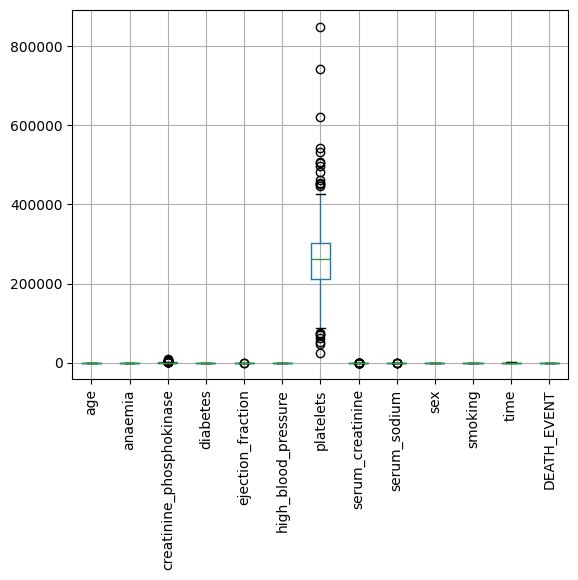

In [7]:
# Checking for outliers
df.boxplot()
plt.xticks(rotation=90)
plt.show()

In [8]:
# Handing outliers
outlier_colms = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
df1 = df.copy()

def handle_outliers(df, colm):
    '''Change the values of outlier to upper and lower whisker values '''
    q1 = df.describe()[colm].loc["25%"]
    q3 = df.describe()[colm].loc["75%"]
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    for i in range(len(df)):
        if df.loc[i,colm] > upper_bound:
            df.loc[i,colm]= upper_bound
        if df.loc[i,colm] < lower_bound:
            df.loc[i,colm]= lower_bound
    return df

for colm in outlier_colms:
    df1 = handle_outliers(df1, colm)

<ipython-input-8-d61ad4af68cb>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1280.25' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,colm]= upper_bound
<ipython-input-8-d61ad4af68cb>:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '67.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i,colm]= upper_bound


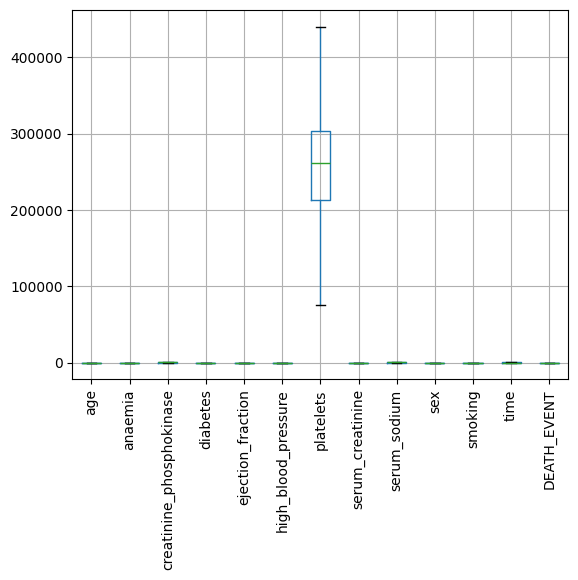

In [9]:
# Recheck for outliers
df1.boxplot()
plt.xticks(rotation=90)
plt.show()

### Split into training and testing set

In [10]:
# Split dataset into training and testing set, considering all features for prediction

X = df1.iloc[:, :-1].values
y = df1['DEATH_EVENT'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state= 123)

In [11]:
X_train[1]

array([6.50e+01, 0.00e+00, 3.95e+02, 1.00e+00, 2.50e+01, 0.00e+00,
       2.65e+05, 1.20e+00, 1.36e+02, 1.00e+00, 1.00e+00, 1.54e+02])

### Model Training

In [12]:
xgb_clf = XGBClassifier(n_estimators=200, max_depth=4, max_leaves=5, random_state=42)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=5,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

### Model Performance

In [13]:
# Accuracy

train_acc = accuracy_score(y_train, xgb_clf.predict(X_train))
test_acc = accuracy_score(y_test, xgb_clf.predict(X_test))
print("Training accuracy: ", train_acc)
print("Testing accuracy: ", test_acc)

Training accuracy:  1.0
Testing accuracy:  0.8444444444444444


In [14]:
# F1-score

train_f1 = f1_score(y_train, xgb_clf.predict(X_train))
test_f1 = f1_score(y_test, xgb_clf.predict(X_test))
print("Training F1 score: ", train_f1)
print("Testing F1 score: ", test_f1)

Training F1 score:  1.0
Testing F1 score:  0.7307692307692307


### Save the trained model

In [15]:
# Prepare versioned save file name
save_file_name = "xgboost-model.pkl"

joblib.dump(xgb_clf, save_file_name)

['xgboost-model.pkl']

## Gradio Implementation

In [16]:
!pip -q install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.9 MB/s eta 0:00:00


In [17]:
import gradio
import joblib
import numpy as np

In [18]:
# Load your trained model

model = joblib.load('xgboost-model.pkl')
df1 = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [19]:
# Function for prediction

def predict_death_event(age, anaemia, creatinine_phosphokinase, diabetes, ejection_fraction,
                        high_blood_pressure, platelets, serum_creatinine, serum_sodium, sex, smoking, time):

    yes_no_map = {'Yes':1, 'No':0}
    gender_map = {'M':1, 'F':0}

    inputs_from_user = [age, yes_no_map[anaemia], creatinine_phosphokinase, yes_no_map[diabetes], ejection_fraction,
                        yes_no_map[high_blood_pressure], platelets, serum_creatinine, serum_sodium, gender_map[sex], yes_no_map[smoking], time]

    inputs_to_model = np.array(inputs_from_user).reshape(1, -1)

    prediction = model.predict(inputs_to_model)[0]
    prob = model.predict_proba(inputs_to_model)[0]*100

    if prediction==1:
        return f"Subject patient will not survive with a probability of {prob[1]:.1f} %"
    elif prediction==0:
        return f"Subject patient will survive with a probability of {prob[0]:.1f} %"
    else:
        return f"Error observed while making prediction"

For categorical user input, user [Radio](https://www.gradio.app/docs/radio) button component.

For numerical user input, user [Slider](https://www.gradio.app/docs/slider) component.

In [20]:
# Description summary of the dataset
df1.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [21]:
# Inputs from user
inputs = [gradio.Slider(df1['age'].min(), df1['age'].max(), label="Enter the age of the patient:"),
          gradio.Radio(["Yes", "No"], label="Whether patient is Anaemic or not?:"),
          gradio.Slider(round(df['creatinine_phosphokinase'].min(),2), round(df1['creatinine_phosphokinase'].max(),2), label="Enter the level of CPK enzyme in the patient's blood (mcg/L):"),
          gradio.Radio(["Yes", "No"], label="Whether patient is diabetic or not?:"),
          gradio.Slider(df1['ejection_fraction'].min(), df1['ejection_fraction'].max(), label="Enter the % of blood leaving the patient's heart at each contraction:"),
          gradio.Radio(["Yes", "No"], label="Whether patient is Hypertensive or not?:"),
          gradio.Slider(df1['platelets'].min(), df1['platelets'].max(), label="Enter the No. of platelets in the patient's blood (kiloplatelets/mL):"),
          gradio.Slider(round(df1['serum_creatinine'].min(),2), round(df1['serum_creatinine'].max(),2), label="Enter the level of serum creatinine in the patient's blood (mg/dL):"),
          gradio.Slider(round(df1['serum_sodium'].min(),2), round(df1['serum_sodium'].max(),2), label="Enter the level of serum sodium in the patient's blood (mEq/L): "),
          gradio.Radio(["M", "F"], label="Choose the sex of the patient:"),
          gradio.Radio(["Yes", "No"], label="Whether the patient smokes or not?:"),
          gradio.Slider(df1['time'].min(), df1['time'].max(), label="Enter the follow-up period (days):"),
          ]

# Output response
outputs = gradio.Textbox(type="text", label='Will the patient survive?')

In [ ]:
# Gradio interface to generate UI link
title = "Patient Survival Prediction"
description = "Predict survival of patient with heart failure, given their clinical record"

iface = gradio.Interface(fn = predict_death_event,
                         inputs = inputs,
                         outputs = outputs,
                         title = title,
                         description = description,
                         allow_flagging='never')

iface.launch(server_name="0.0.0.0", server_port = 8001, share = True, debug=True)  # server_name="0.0.0.0", server_port = 8001   # Ref: https://www.gradio.app/docs/interface

/usr/local/lib/python3.10/dist-packages/gradio/interface.py:393: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://779c559eb088c50641.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
